In [1]:
# importing libraries
!pip install transformers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
import os,re
import warnings
warnings.filterwarnings('ignore')
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
import tensorflow as tf
from tqdm import tqdm, trange
import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from transformers import *

     |████████████████████████████████| 778kB 4.6MB/s 
     |████████████████████████████████| 3.0MB 24.0MB/s 
     |████████████████████████████████| 890kB 59.0MB/s 
     |████████████████████████████████| 1.1MB 55.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=f79e85f11c9c54767060ac2f01affc527ff8dbb561b35bf3d37ca7f4a6f5ad54
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# reading dataset
train_df = pd.read_csv('/content/drive/My Drive/janatahack/train.csv')
test_df = pd.read_csv('/content/drive/My Drive/janatahack/test.csv')

In [3]:
# checking for nulll values
train_df.isnull().sum() 

ID                      0
TITLE                   0
ABSTRACT                0
Computer Science        0
Physics                 0
Mathematics             0
Statistics              0
Quantitative Biology    0
Quantitative Finance    0
dtype: int64

In [4]:
test_df.isnull().sum()

ID          0
TITLE       0
ABSTRACT    0
dtype: int64

In [5]:
# number of classes
cols = train_df.columns
label_cols = list(cols[3:9])
label_cols

['Computer Science',
 'Physics',
 'Mathematics',
 'Statistics',
 'Quantitative Biology',
 'Quantitative Finance']

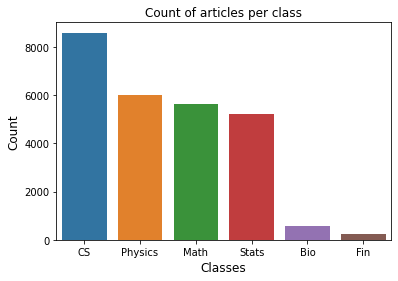

In [6]:
# plotting number of classes and their count of articles
sns.barplot(['CS','Physics','Math','Stats','Bio','Fin'], train_df.iloc[:,3:9].sum().values)
plt.title('Count of articles per class')
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

In [7]:
# stopwords list and stemmer 
stop_words = stopwords.words('english')
stemmer = PorterStemmer()

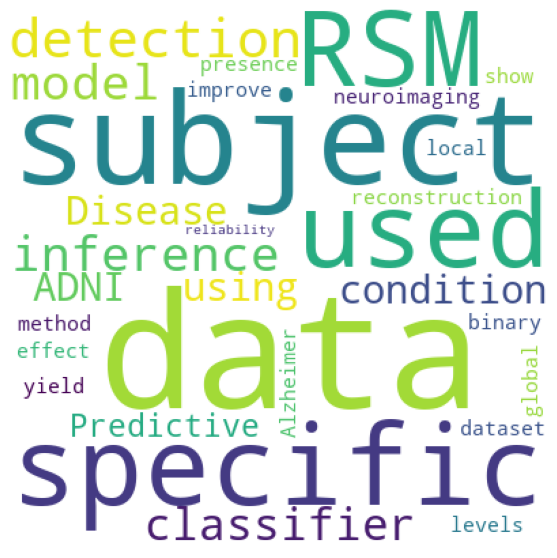

In [8]:
# plotting wordcloud 
wordcloud = WordCloud(width = 400, height = 400, background_color ='white', stopwords = stop_words, 
                min_font_size = 10).generate(train_df['ABSTRACT'][0]) 
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.show()

In [9]:
# function for cleaning data - removing stopwords , punctuations , etc
def clean_text(df):
  for i in range(0,len(df)):
    text = re.sub('[^a-zA-Z]', ' ', df['ABSTRACT'][i])
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if not word in stop_words]
    text = ' '.join(text)
    df['ABSTRACT'][i] = text
  return df

In [10]:
# cleaning train data 
train_df = clean_text(train_df)

In [11]:
# cleaning test data
test_df = clean_text(test_df)

In [12]:
# converting train data classes into one hot label list
train_df['one_hot_labels'] = list(train_df[label_cols].values)
labels = list(train_df['one_hot_labels'].values)
abstract = list(train_df['ABSTRACT'].values)

In [13]:
# average abstract length
train_df.insert(10,'Length',0)
for i in range(0,len(train_df)):
  train_df['Length'][i] = len(train_df['ABSTRACT'][i])
train_df['Length'].mean()

630.3024508868968

In [14]:
# initalise max length , bert tokenizer and encoding train data
max_length = 200 # less in order to avoid memory error 
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
encodings = tokenizer.batch_encode_plus(abstract,max_length=max_length,pad_to_max_length=True,truncation=True) 

In [15]:
# loading necessary encoded values 
input_ids = encodings['input_ids'] 
token_type_ids = encodings['token_type_ids'] 
attention_masks = encodings['attention_mask']

In [16]:
# splitting data into training and validation
train_inputs, validation_inputs, train_labels, validation_labels, train_token_types, validation_token_types, train_masks, validation_masks = train_test_split(input_ids, labels,
token_type_ids,attention_masks, random_state=200, test_size=0.20)

In [17]:
# converting all numpy arrays to tensors
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
train_token_types = torch.tensor(train_token_types)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)
validation_token_types = torch.tensor(validation_token_types)

In [18]:
# initialise batch size 
batch_size = 32

In [19]:
# creating data loader and loading data into it using random sampler
train_data = TensorDataset(train_inputs, train_masks, train_labels, train_token_types)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels, validation_token_types)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [20]:
# saving data loaders
torch.save(validation_dataloader,'validation_data_loader')
torch.save(train_dataloader,'train_data_loader')

In [21]:
# loading pretrained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [22]:
# enabling GPU
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [23]:
# initialising optimizer
optimizer = AdamW(model.parameters(),lr=3e-5,correct_bias=True)

In [24]:
# device name of GPU
device = 'cuda'
torch.cuda.get_device_name(0)

'Tesla T4'

In [25]:
epochs = 5
val_acc_list = []
for _ in trange(epochs, desc="Epoch"):

  # set model to training mode 
  model.train()

  # train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    batch = tuple(t.to(device) for t in batch)
    # unpack the inputs from dataloader
    b_input_ids, b_input_mask, b_labels, b_token_types = batch
    # clearing the gradients
    optimizer.zero_grad()

    # forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]
    loss_func = BCEWithLogitsLoss() 
    # converting logits and labels to appropriate shape 
    loss = loss_func(logits.view(-1,6),b_labels.type_as(logits).view(-1,6)) 

    # backward pass
    loss.backward()
    # update parameters and take a step using the computed gradient
    optimizer.step()

  # set model to evaluation mode
  model.eval()

  # variables to gather outputs
  logit_preds,true_labels,pred_labels = [],[],[]


  # predict
  for i, batch in enumerate(validation_dataloader):
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_token_types = batch
    with torch.no_grad():
      # forward pass
      outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      b_logit_pred = outs[0]
      pred_label = torch.sigmoid(b_logit_pred)

      # converting tensors to numpy arrays
      b_logit_pred = b_logit_pred.detach().cpu().numpy()
      pred_label = pred_label.to('cpu').numpy()
      b_labels = b_labels.to('cpu').numpy()

    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

  # flatten outputs
  pred_labels = [item for sublist in pred_labels for item in sublist]
  true_labels = [item for sublist in true_labels for item in sublist]

  # calculate accuracy
  threshold = 0.40
  pred_bools = [pl>threshold for pl in pred_labels]
  true_bools = [tl==1 for tl in true_labels]
  val_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')*100
  val_acc_list.append(val_f1_accuracy)
  print('F1 Validation Accuracy: ', val_f1_accuracy)

Epoch:  20%|██        | 1/5 [11:07<44:29, 667.45s/it]

F1 Validation Accuracy:  81.30902290790088


Epoch:  40%|████      | 2/5 [22:22<33:29, 669.78s/it]

F1 Validation Accuracy:  82.98211107989135


Epoch:  60%|██████    | 3/5 [33:36<22:22, 671.07s/it]

F1 Validation Accuracy:  81.99025487256372


Epoch:  80%|████████  | 4/5 [44:51<11:12, 672.12s/it]

F1 Validation Accuracy:  82.65024811615513


Epoch: 100%|██████████| 5/5 [56:06<00:00, 673.38s/it]

F1 Validation Accuracy:  81.73801212566599


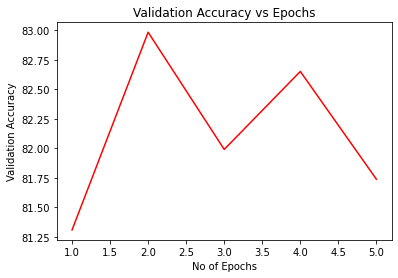

In [26]:
# plotting validation accuracy vs epochs
epoch_list = [ i for i in range(1,epochs+1) ]
plt.title('Validation Accuracy vs Epochs')
plt.plot(epoch_list,val_acc_list,'red')
plt.xlabel('No of Epochs')
plt.ylabel('Validation Accuracy')
plt.show()

In [27]:
# save model
torch.save(model.state_dict(), 'bert_model_topic')

In [28]:
# preparing test data 
test_df.insert(3, "Computer Science", 0) 
test_df.insert(4, "Physics", 0)
test_df.insert(5, "Mathematics", 0)
test_df.insert(6, "Statistics", 0)
test_df.insert(7, "Quantitative Biology", 0)
test_df.insert(8, "Quantitative Finance", 0)

In [29]:
# one hot labels for test data
test_label_cols = list(test_df.columns[4:])
test_df['one_hot_labels'] = list(test_df[test_label_cols].values)

In [30]:
test_labels = list(test_df['one_hot_labels'].values)
test_abstract = list(test_df['ABSTRACT'].values)

In [31]:
# encoding test data
test_encodings = tokenizer.batch_encode_plus(test_abstract,max_length=max_length,pad_to_max_length=True,truncation=True)
test_input_ids = test_encodings['input_ids']
test_token_type_ids = test_encodings['token_type_ids']
test_attention_masks = test_encodings['attention_mask']

In [32]:
# converting test data into tensors
test_inputs = torch.tensor(test_input_ids)
test_labels = torch.tensor(test_labels)
test_masks = torch.tensor(test_attention_masks)
test_token_types = torch.tensor(test_token_type_ids)

In [33]:
# create test dataloader 
test_data = TensorDataset(test_inputs, test_masks, test_labels, test_token_types)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [34]:
# save test dataloader
torch.save(test_dataloader,'test_data_loader')

In [35]:
# testing 

# put model in evaluation mode 
model.eval()

logit_preds,pred_labels = [],[]

# predict
# reading input from each batch
for i, batch in enumerate(test_dataloader):
  batch = tuple(t.to(device) for t in batch)
  # unpack the inputs from test dataloader
  b_input_ids, b_input_mask, b_labels, b_token_types = batch
  with torch.no_grad():
    # forward pass
    outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    b_logit_pred = outs[0]
    pred_label = torch.sigmoid(b_logit_pred)

    # converting into numpy arrays 
    b_logit_pred = b_logit_pred.detach().cpu().numpy()
    pred_label = pred_label.to('cpu').numpy()
    b_labels = b_labels.to('cpu').numpy()

  # appending output variables 
  logit_preds.append(b_logit_pred)
  pred_labels.append(pred_label)

# flatten output variables
pred_labels = [item for sublist in pred_labels for item in sublist]

# converting flattened binary values to boolean values
pred_bools = [pl>0.4 for pl in pred_labels] 

In [36]:
# dictonary of classes and respective encoded ids
idx2label = dict(zip(range(6),label_cols))
print(idx2label)

{0: 'Computer Science', 1: 'Physics', 2: 'Mathematics', 3: 'Statistics', 4: 'Quantitative Biology', 5: 'Quantitative Finance'}


In [37]:
# appending ids to list 
pred_label_ids=[]
for vals in pred_bools:
  pred_label_ids.append(np.where(vals)[0].flatten().tolist())

In [38]:
# converting ids to texts
pred_label_texts = []
for vals in pred_label_ids:
  if vals:
    pred_label_texts.append([idx2label[val] for val in vals])
  else:
    pred_label_texts.append(vals)

In [39]:
# output dataframe
output_df = pd.DataFrame({'pred_labels':pred_label_texts})
output_df.head()

,pred_labels
0,[Mathematics]
1,[Mathematics]
2,[Physics]
3,[Quantitative Finance]
4,"[Mathematics, Quantitative Finance]"


In [40]:
# preparing output dataframe
output_df.insert(0,'ID','0')
output_df['ID'] = test_df['ID']
output_df.insert(2, "Computer Science", 0) 
output_df.insert(3, "Physics", 0)
output_df.insert(4, "Mathematics", 0)
output_df.insert(5, "Statistics", 0)
output_df.insert(6, "Quantitative Biology", 0)
output_df.insert(7, "Quantitative Finance", 0)

In [41]:
# converting encoded ids to textual labels
for i in range(0,len(output_df)):
  for j in range(0,len(output_df.iloc[:,1][i])):
    if output_df.iloc[:,1][i][j] == 'Computer Science':
      output_df.iloc[:,2][i] = 1
    elif output_df.iloc[:,1][i][j] =='Phyiscs':
        output_df.iloc[:,3][i] = 1
    elif output_df.iloc[:,1][i][j] =='Mathematics':
        output_df.iloc[:,4][i] = 1
    elif output_df.iloc[:,1][i][j] =='Statistics':
        output_df.iloc[:,5][i] = 1
    elif output_df.iloc[:,1][i][j] =='Quantitative Biology':
        output_df.iloc[:,6][i] = 1
    elif output_df.iloc[:,1][i][j] =='Quantitative Finance':
        output_df.iloc[:,7][i] = 1

In [42]:
# dropping unnecessary columns
output_df.drop(['pred_labels'],inplace=True,axis=1)

In [43]:
# saving final output dataframe into csv file
output_df.to_csv('bert_submission.csv',index=False)